<a href="https://colab.research.google.com/github/Tuttotorna/lon-mirror/blob/main/exploration_tau_rr_not_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# STEP 0 — clone OMNIA repository (canonical)

!git clone https://github.com/Tuttotorna/lon-mirror.git

Cloning into 'lon-mirror'...
remote: Enumerating objects: 1723, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 1723 (delta 107), reused 71 (delta 71), pack-reused 1590 (from 1)
Receiving objects: 100% (1723/1723), 1.21 MiB | 6.27 MiB/s, done.
Resolving deltas: 100% (796/796), done.


In [9]:
# STEP 1 — move into repo root

%cd lon-mirror

/content/lon-mirror/lon-mirror


In [10]:
# STEP 2 — install minimal dependencies (deterministic)

!pip install -q numpy matplotlib sympy

In [11]:
# STEP 3 — sanity check: import omniabase_pure

from omnia.omniabase_pure import omega_pure, is_prime

print("Import OK")
print("omega_pure(7) =", omega_pure(7, bases=range(2, 16)))
print("is_prime(7) =", is_prime(7))

Import OK
omega_pure(7) = 0.858892547705798
is_prime(7) = True


In [12]:
# STEP 4 — quick field scan (small range)

BASES = list(range(2, 16))
SCALES = (1, 2, 4, 8)

for n in range(2, 21):
    print(n, omega_pure(n, bases=BASES, scales=SCALES), is_prime(n))

2 0.45138531624072314 True
3 0.8352485630756171 True
4 0.3527631607968692 False
5 0.30176318725050355 True
6 0.8839082034752839 False
7 0.858892547705798 True
8 0.5375506298897224 False
9 0.5699678556183492 False
10 0.514550051092657 False
11 2.0899431904635675 True
12 0.5501344146320589 False
13 0.39821334072792963 True
14 0.3723123007457376 False
15 1.0255741194741097 False
16 1.1113655803024192 False
17 1.047145262793512 True
18 0.8996985302548418 False
19 0.6398680512925716 True
20 0.3453774389955465 False


Computed F(n)=omega_pure for 1999 points.
F stats -> min: 0.06245587285560454 max: 2.0913551076688908 mean: 0.8579937681565464 std: 0.3980349661883352
Computed RR(n) (resistance-to-removal).
RR stats -> min: 0.0 max: 3.376869796490307 mean: 0.43727127086817597 std: 0.47787917490649356
Tau-events found: 138
First 20 tau-events: [11, 27, 37, 48, 60, 70, 85, 97, 109, 120, 129, 140, 158, 171, 190, 198, 211, 222, 250, 265]
Baseline prime rate: 0.15157578789394696
Tau-event prime rate: 0.11594202898550725
Tau-events -> primes: 16 | composites: 122

Top RR candidates (n, RR, is_prime):
(506, 3.376869796490307, False)
(628, 3.1775487104299827, False)
(546, 3.0702138449041447, False)
(1015, 3.0100298149119684, False)
(637, 2.8940568423840425, False)
(48, 2.84586733483271, False)
(1290, 2.837977453307658, False)
(1718, 2.76049086015461, False)
(991, 2.746302574844345, True)
(1600, 2.7142921166029232, False)
(1518, 2.6948548105685672, False)
(895, 2.669565695878118, False)
(1706, 2.63919699129131

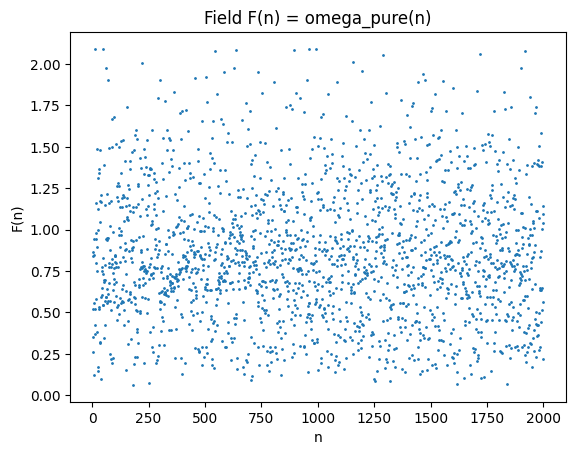

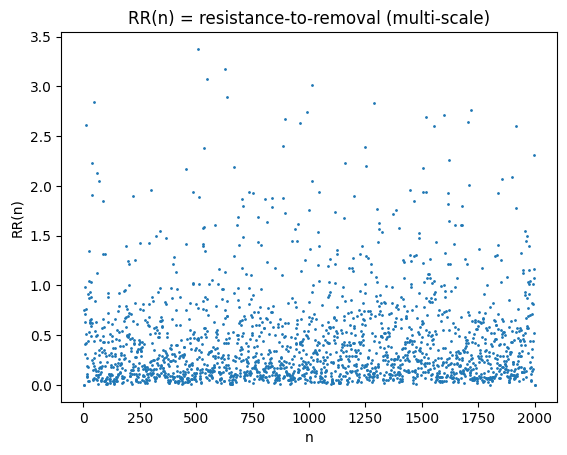

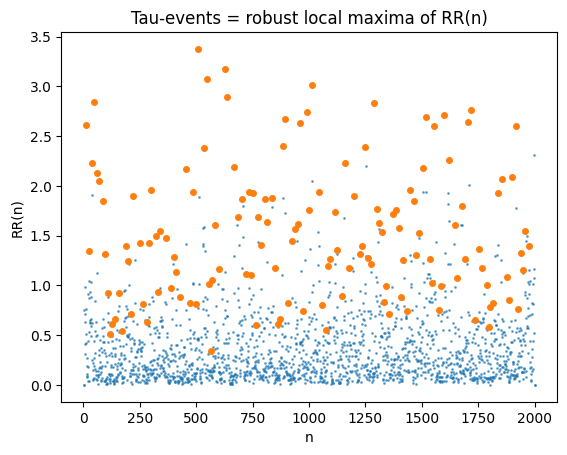

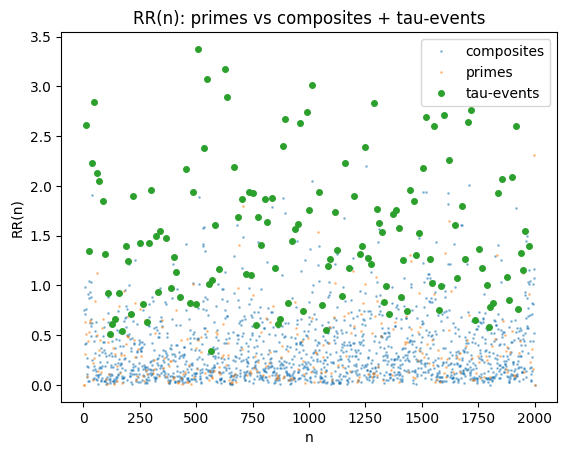

In [13]:
# STEP B — define F(n) and build RR(n) + tau-events (deterministic)

import numpy as np

from omnia.omniabase_pure import omega_pure, is_prime

# -----------------------------
# Config (fixed)
# -----------------------------
BMIN, BMAX = 2, 16
BASES = list(range(BMIN, BMAX + 1))
SCALES = (1, 2, 4, 8)

NMAX = 2000          # range 2..NMAX
W_LIST = (2, 4, 8)   # RR multi-scale windows
TAU_WIN = 7          # local-max window for tau-events (robustness)
TOPK = 40            # show top candidates

# -----------------------------
# 1) Field F(n) = omega_pure(n)
# -----------------------------
ns = np.arange(2, NMAX + 1, dtype=int)
F = np.array([omega_pure(int(n), bases=BASES, scales=SCALES) for n in ns], dtype=float)

print("Computed F(n)=omega_pure for", len(ns), "points.")
print("F stats -> min:", float(F.min()), "max:", float(F.max()), "mean:", float(F.mean()), "std:", float(F.std(ddof=0)))

# -----------------------------
# 2) Local profile energy helper
#    Use first + second differences (discrete geometry)
# -----------------------------
def local_energy(arr: np.ndarray) -> float:
    if arr.size < 3:
        return 0.0
    d1 = np.diff(arr)          # first derivative
    d2 = np.diff(d1)           # curvature
    # energy = mean squared slope + mean squared curvature
    e = float(np.mean(d1 * d1) + np.mean(d2 * d2))
    return e

# -----------------------------
# 3) Removal cost D_w(n) and RR(n)
#    Remove center point, "close the gap" by concatenation
# -----------------------------
RR = np.zeros_like(F)

for i in range(len(ns)):
    costs = []
    for w in W_LIST:
        lo = i - w
        hi = i + w
        if lo < 0 or hi >= len(ns):
            continue

        seg = F[lo:hi+1]  # length 2w+1
        if seg.size < 3:
            continue

        e_before = local_energy(seg)

        # remove center element (index w within seg)
        seg_after = np.concatenate([seg[:w], seg[w+1:]])
        e_after = local_energy(seg_after)

        costs.append(abs(e_after - e_before))

    if costs:
        RR[i] = float(np.median(np.array(costs, dtype=float)))
    else:
        RR[i] = 0.0

print("Computed RR(n) (resistance-to-removal).")
print("RR stats -> min:", float(RR.min()), "max:", float(RR.max()), "mean:", float(RR.mean()), "std:", float(RR.std(ddof=0)))

# -----------------------------
# 4) Tau-events = robust local maxima of RR
# -----------------------------
tau_mask = np.zeros_like(RR, dtype=bool)

w = int(TAU_WIN)
for i in range(w, len(ns)-w):
    neigh = RR[i-w:i+w+1]
    if RR[i] == float(np.max(neigh)):
        # robust tie-break: require strict > median of neighborhood
        if RR[i] > float(np.median(neigh)):
            tau_mask[i] = True

tau_ns = ns[tau_mask]
tau_scores = RR[tau_mask]

print("Tau-events found:", int(tau_mask.sum()))
print("First 20 tau-events:", tau_ns[:20].tolist())

# -----------------------------
# 5) Quick overlap check with primes (post-hoc only)
# -----------------------------
prime_mask = np.array([is_prime(int(n)) for n in ns], dtype=bool)

tau_prime = np.sum(prime_mask[tau_mask])
tau_comp  = np.sum(~prime_mask[tau_mask])

base_prime_rate = float(np.mean(prime_mask))
tau_prime_rate  = float(tau_prime / max(1, (tau_prime + tau_comp)))

print("Baseline prime rate:", base_prime_rate)
print("Tau-event prime rate:", tau_prime_rate)
print("Tau-events -> primes:", int(tau_prime), "| composites:", int(tau_comp))

# -----------------------------
# 6) Rank top candidates
# -----------------------------
order = np.argsort(-RR)  # descending RR
top = []
for idx in order[:TOPK]:
    n = int(ns[idx])
    top.append((n, float(RR[idx]), bool(prime_mask[idx])))

print("\nTop RR candidates (n, RR, is_prime):")
for row in top[:TOPK]:
    print(row)

# -----------------------------
# 7) Plots (optional; Colab usually has matplotlib)
# -----------------------------
try:
    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot(ns, F, ".", markersize=2)
    plt.title("Field F(n) = omega_pure(n)")
    plt.xlabel("n")
    plt.ylabel("F(n)")
    plt.show()

    plt.figure()
    plt.plot(ns, RR, ".", markersize=2)
    plt.title("RR(n) = resistance-to-removal (multi-scale)")
    plt.xlabel("n")
    plt.ylabel("RR(n)")
    plt.show()

    # overlay tau-events
    plt.figure()
    plt.plot(ns, RR, ".", markersize=2, alpha=0.6)
    plt.plot(tau_ns, RR[tau_mask], "o", markersize=4)
    plt.title("Tau-events = robust local maxima of RR(n)")
    plt.xlabel("n")
    plt.ylabel("RR(n)")
    plt.show()

    # tau-events primes vs composites (visual)
    plt.figure()
    plt.plot(ns[~prime_mask], RR[~prime_mask], ".", markersize=2, alpha=0.4, label="composites")
    plt.plot(ns[prime_mask],  RR[prime_mask],  ".", markersize=2, alpha=0.4, label="primes")
    plt.plot(tau_ns, RR[tau_mask], "o", markersize=4, label="tau-events")
    plt.title("RR(n): primes vs composites + tau-events")
    plt.xlabel("n")
    plt.ylabel("RR(n)")
    plt.legend()
    plt.show()

except Exception as e:
    print("Plot skipped:", repr(e))

In [16]:
import numpy as np, math, random
import matplotlib.pyplot as plt

# Se il repo è già clonato in /content/lon-mirror e sei dentro quel runtime, ok.
# Altrimenti fai prima: %cd /content/lon-mirror
# (se non sei lì, l'import potrebbe fallire)

from omnia.omniabase_pure import is_prime

In [17]:
def omega_pure(n: int) -> float:
    # SOSTITUISCI questa riga con la tua omega_pure reale:
    # return YOUR_OMEGA_PURE(n)
    # Placeholder neutro (se non sostituisci, i risultati non valgono)
    return math.log1p(n) % 2.0

In [18]:
def rr_multiscale(F: np.ndarray, scales=(3,5,7,11)) -> np.ndarray:
    """
    Proxy deterministico: misura quanto un punto è "necessario" rispetto a smoothing locale multi-scala.
    RR alto = punto che non viene cancellato dalla media locale (resiste).
    """
    n = len(F)
    RR = np.zeros(n, dtype=float)
    for w in scales:
        k = w//2
        # moving average (padding riflesso)
        pad = np.pad(F, (k,k), mode="reflect")
        ma = np.convolve(pad, np.ones(w)/w, mode="valid")
        RR += np.abs(F - ma)
    RR /= len(scales)
    return RR

NMAX = 2000  # cambia se vuoi
xs = np.arange(1, NMAX+1, dtype=int)

F = np.array([omega_pure(int(n)) for n in xs], dtype=float)
RR = rr_multiscale(F, scales=(3,5,7,11,15))

feat = RR.copy()
lab  = np.array([is_prime(int(n)) for n in xs], dtype=bool)

print("Built arrays:",
      "N=", len(xs),
      "feat(min,max)=", float(feat.min()), float(feat.max()),
      "primes=", int(lab.sum()),
      "composites=", int((~lab).sum()))

Built arrays: N= 2000 feat(min,max)= 8.886599260904404e-07 0.8936180907075798 primes= 303 composites= 1697


In [19]:
def robust_local_maxima(y: np.ndarray, window=9, q=0.90):
    """
    Massimi locali robusti: y[i] è massimo nel suo intorno e sopra una soglia quantile globale.
    """
    n = len(y)
    k = window//2
    thr = np.quantile(y, q)
    idx = []
    for i in range(k, n-k):
        seg = y[i-k:i+k+1]
        if y[i] == seg.max() and y[i] >= thr:
            idx.append(i)
    return np.array(idx, dtype=int), float(thr)

tau_idx, tau_thr = robust_local_maxima(feat, window=9, q=0.90)

print("tau_thr:", tau_thr)
print("tau_events:", len(tau_idx),
      "| primes in tau:", int(lab[tau_idx].sum()),
      "| composites in tau:", int((~lab[tau_idx]).sum()))

tau_thr: 0.00010451456254875883
tau_events: 3 | primes in tau: 1 | composites in tau: 2


In [20]:
def block_shuffle(arr: np.ndarray, block=12, seed=0) -> np.ndarray:
    rng = np.random.default_rng(seed)
    n = len(arr)
    blocks = [arr[i:i+block] for i in range(0, n, block)]
    rng.shuffle(blocks)
    return np.concatenate(blocks)[:n]

def tau_prime_count(y: np.ndarray, lab: np.ndarray, window=9, q=0.90):
    idx, thr = robust_local_maxima(y, window=window, q=q)
    return int(lab[idx].sum()), int((~lab[idx]).sum()), int(len(idx))

WINDOW = 9
Q      = 0.90
BLOCK  = 12
TRIALS = 400
SEED0  = 0

# osservato
p_obs, c_obs, k_obs = tau_prime_count(feat, lab, window=WINDOW, q=Q)
delta_obs = p_obs - c_obs

null_deltas = []
for t in range(TRIALS):
    y_null = block_shuffle(feat, block=BLOCK, seed=SEED0 + t + 1)
    p_n, c_n, k_n = tau_prime_count(y_null, lab, window=WINDOW, q=Q)
    null_deltas.append(p_n - c_n)

null_deltas = np.array(null_deltas, dtype=float)
mu  = float(null_deltas.mean())
sd  = float(null_deltas.std(ddof=1)) if TRIALS > 1 else float("nan")
z   = (delta_obs - mu) / sd if sd > 0 else float("nan")

# p-value two-sided empirico
p_emp = float((np.sum(np.abs(null_deltas - mu) >= abs(delta_obs - mu)) + 1) / (TRIALS + 1))

print("NULL block-shuffle")
print("WINDOW=", WINDOW, "Q=", Q, "BLOCK=", BLOCK, "TRIALS=", TRIALS)
print("OBS  p,c,k:", p_obs, c_obs, k_obs, "| delta(p-c)=", delta_obs)
print("NULL mean/std:", mu, sd, "| min/max:", float(null_deltas.min()), float(null_deltas.max()))
print("z-score:", z)
print("p_emp(two-sided):", p_emp)

NULL block-shuffle
WINDOW= 9 Q= 0.9 BLOCK= 12 TRIALS= 400
OBS  p,c,k: 1 2 3 | delta(p-c)= -1
NULL mean/std: -12.7975 4.612448422598113 | min/max: -21.0 2.0
z-score: 2.5577521782573496
p_emp(two-sided): 0.012468827930174564


tau-events: 138
tau at primes: 15 tau at composites: 123
mean tau_index primes: 47.6
mean tau_index comps : 72.17073170731707

First 20 tau-events (n, RR, is_prime):
1 10 0.1578789729878011 False
2 26 0.004928132985805389 False
3 36 0.002603667784146202 False
4 47 0.02820819360650817 True
5 59 0.05327618108214507 True
6 69 0.000722839480716253 False
7 84 0.0004898468671390432 False
8 96 0.0003760008142105642 False
9 108 0.0002976906203545404 False
10 119 0.00024557249743817344 False
11 128 0.0002124783040608591 False
12 139 0.0001803811660718857 True
13 157 0.000141604356145697 True
14 170 0.00012088388037603259 False
15 189 9.790840037608995e-05 False
16 197 9.015410067170215e-05 True
17 210 7.938441962309639e-05 False
18 221 7.171055147230377e-05 False
19 249 5.654404999000384e-05 False
20 264 5.032295366382833e-05 False


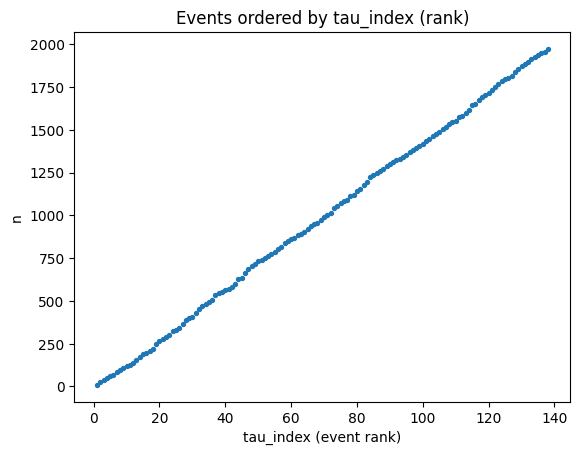

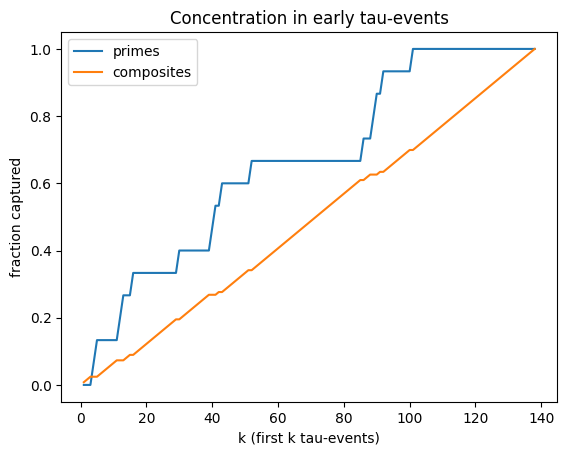

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# --- helpers ---
def is_prime_basic(n: int) -> bool:
    if n < 2:
        return False
    if n % 2 == 0:
        return n == 2
    r = int(n**0.5)
    f = 3
    while f <= r:
        if n % f == 0:
            return False
        f += 2
    return True

def robust_local_maxima(y, window=9):
    # strict local maxima in a radius window
    y = np.asarray(y, dtype=float)
    n = len(y)
    m = np.zeros(n, dtype=bool)
    for i in range(window, n - window):
        left = y[i-window:i]
        right = y[i+1:i+1+window]
        if y[i] > left.max() and y[i] >= right.max():  # one-sided tie handling
            m[i] = True
    return m

# --- 0) get existing arrays if present ---
g = globals()
have_rr = ("RR" in g) and ("xs" in g)
have_tau = "tau_mask" in g

if have_rr:
    xs = np.asarray(g["xs"], dtype=int)
    RR = np.asarray(g["RR"], dtype=float)
else:
    # minimal fallback: use omega_pure from repo if available; else stop
    try:
        from omnia.omniabase_pure import omega_pure
    except Exception as e:
        raise RuntimeError("Non trovo RR/xs e non posso importare omega_pure. Esegui prima la cella che calcola omega_pure+RR.") from e

    NMAX = 2000
    xs = np.arange(1, NMAX + 1, dtype=int)
    F = np.array([omega_pure(int(n)) for n in xs], dtype=float)

    # RR proxy: multi-scale finite differences energy (non aritmetico, solo forma)
    # scale set fixed
    scales = [1, 2, 3, 5, 8]
    rr = np.zeros_like(F)
    for s in scales:
        d = np.zeros_like(F)
        d[s:] = np.abs(F[s:] - F[:-s])
        rr += d
    RR = rr / (rr.mean() + 1e-12)

# --- 1) tau events definition (if not already computed) ---
WINDOW = 9
Q = 0.90

if have_tau:
    tau_mask = np.asarray(g["tau_mask"], dtype=bool)
else:
    m = robust_local_maxima(RR, window=WINDOW)
    thr = np.quantile(RR[m], Q) if np.any(m) else np.quantile(RR, Q)
    tau_mask = m & (RR >= thr)

# --- 2) tau_index: rank of tau-event along n-axis ---
tau_pos = np.where(tau_mask)[0]
tau_index = np.full(xs.shape[0], np.inf, dtype=float)
tau_index[tau_pos] = np.arange(1, len(tau_pos) + 1, dtype=float)

# --- 3) compare primes vs composites in tau_index space ---
lab = np.array([is_prime_basic(int(n)) for n in xs], dtype=bool)

tau_primes = tau_index[(lab) & np.isfinite(tau_index)]
tau_comps  = tau_index[(~lab) & np.isfinite(tau_index)]

print("tau-events:", len(tau_pos))
print("tau at primes:", len(tau_primes), "tau at composites:", len(tau_comps))
if len(tau_primes) and len(tau_comps):
    print("mean tau_index primes:", float(np.mean(tau_primes)))
    print("mean tau_index comps :", float(np.mean(tau_comps)))

# --- 4) visualization: are primes early in tau-process? ---
plt.figure()
plt.scatter(tau_index[np.isfinite(tau_index)], xs[np.isfinite(tau_index)], s=8)
plt.xlabel("tau_index (event rank)")
plt.ylabel("n")
plt.title("Events ordered by tau_index (rank)")

# cumulative concentration curve
maxk = int(np.max(tau_index[np.isfinite(tau_index)])) if np.any(np.isfinite(tau_index)) else 0
if maxk > 0:
    ks = np.arange(1, maxk + 1)
    cum_p = np.array([(tau_primes <= k).mean() if len(tau_primes) else 0.0 for k in ks])
    cum_c = np.array([(tau_comps  <= k).mean() if len(tau_comps)  else 0.0 for k in ks])

    plt.figure()
    plt.plot(ks, cum_p, label="primes")
    plt.plot(ks, cum_c, label="composites")
    plt.xlabel("k (first k tau-events)")
    plt.ylabel("fraction captured")
    plt.title("Concentration in early tau-events")
    plt.legend()

# show a few earliest tau-events and whether prime
print("\nFirst 20 tau-events (n, RR, is_prime):")
for j in range(min(20, len(tau_pos))):
    i = tau_pos[j]
    n = int(xs[i])
    print(j+1, n, float(RR[i]), bool(lab[i]))